In [1]:
from chemtbd.io import Agilent
from scipy.stats import linregress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
agi = Agilent.from_root('data/test3')

__matchlib2area__ matches lib dataframe to fid or tic dataframes for all data sets in a folder containing .D files generated from Agilent. The input is two dataframes from agi, agi_results_lib and agi.results_tic. The later can also be agi.results_fid

example:
```
matched_df = matchlib2area_all(agi.results_lib,agi.results_tic)
```

In [3]:
libdf = (agi.results_lib)
areadf = (agi.results_tic)

def find_match(x, Y):
    ''' find index of argmin lambda(x,Y)
    '''
    score = lambda y: (x - y)**2
    return Y.apply(score).idxmin()

def rt_match(lib_row, rt):
    ''' find closest rt
    '''
    x, i = lib_row.rt, lib_row.name
    return find_match(x, rt[i:])

def matchiter(libdf,areadf):
    '''match area on rt from single df
    '''
    xi = libdf.apply(rt_match, rt=areadf.rt.sort_values(), axis=1)
    libdf['area'] = areadf.area[xi].values
    return libdf.set_index('key')
    
def matchlib2area(libdf,areadf):
    '''match area from many datafrmas
    '''
    libdf_grouped = (libdf.groupby(libdf.index))
    areadf_grouped = (areadf.groupby(areadf.index))
    returndf = libdf_grouped.apply(lambda x: matchiter(x.reset_index(),areadf_grouped.get_group(x.name).reset_index()))    
    return returndf

matcheddf = matchlib2area(libdf,areadf)
matcheddf.head()

,header=,pk,rt,pct_area,library_id,ref,cas,qual,area
key,,,,,,,,,
FA03.D,1=,1.0,5.7877,2.0335,Methyl octanoate,17.0,000000-00-0,96.0,1489466.0
FA03.D,2=,2.0,7.3441,3.4015,Methyl decanoate,1.0,000000-00-0,98.0,2491449.0
FA03.D,3=,3.0,8.0364,1.7448,Methyl undecanoate,2.0,000000-00-0,98.0,1277982.0
FA03.D,4=,4.0,8.6715,3.9674,Methyl dodecanoate,3.0,000000-00-0,98.0,2905961.0
FA03.D,5=,5.0,9.2781,1.9607,Methyl tridecanoate,4.0,000000-00-0,99.0,1436154.0


This creates a df containing the concentrations, I assumed the starting concentration of the stock was 1M, to get from hanna. The general data input represented by __calc_conc_df__ will always be this format; however, we will need to have a different ways for the user to input this information

In [4]:
cal_files = ['FA03.D','FA04.D','FA05.D']
cal_dilutions = {'FA03.D': 0.25,'FA04.D':0.50,'FA05.D':1.0}
standards = pd.DataFrame({'library_id':list(set(agi.results_lib.library_id)),'Conc_0':1})

for key,val in cal_dilutions.items():
    standards[key] = standards['Conc_0']*val
standards.drop('Conc_0',1,inplace=True)
standards.head()

,library_id,FA03.D,FA04.D,FA05.D
0,cis-10-Pentadecenoic acid methyl ester,0.25,0.5,1.0
1,Methyl stearate,0.25,0.5,1.0
2,Methyl lignocerate,0.25,0.5,1.0
3,"All cis-4,7,10,13,16,19-docosahexaenoate methy...",0.25,0.5,1.0
4,Methyl pentadecanoate,0.25,0.5,1.0


Calculate a linear fit to calibration data for each species

In [5]:
def match_cal_conc(matcheddf, standards):
    '''
    this  function takes a dataframe which contains species matched to an area (matched_df) 
    and a calibration concentration dataframe and matches these two based on library_id
    '''
    standards_melted = pd.melt(standards, id_vars=['library_id'],value_vars=cal_files)
    standards_melted.columns = ['library_id','key','cal_conc']
    
    return_df = pd.merge(matcheddf.reset_index(),standards_melted,how='left',on=['library_id','key'])
    return return_df.dropna(subset=['cal_conc'])

def cal_curves(matched_cal_conc):
    '''
    this function takes a matched calibration concentration dataframe (matched_cal_conc)
    and does a linear regression and returns a dataframe of the library_ids with 
    linregress stats and the min/max areas which is the range for which the calibration
    curve can (should only) be used.
    
    this is only for cases where each molecule has a calibration curve i.e. tic and/or fid
    '''
    b = (matched_cal_conc.groupby('library_id')
                         .apply(lambda a: linregress(a.area,a.cal_conc))
                         .apply(pd.Series)
                         .reset_index())
    b.columns = ['library_id','slope','intercept','rvalue','pvalue','stderr']
    
    d = pd.DataFrame({'max':matched_cal_conc.groupby('library_id')['area'].max(),
                    'min':matched_cal_conc.groupby('library_id')['area'].min()}).reset_index()
    return pd.merge(b,d,on='library_id')

matched_cal_conc = match_cal_conc(matcheddf, standards)
calced_curves = cal_curves(matched_cal_conc)
calced_curves.head()


D:\Applications\Anaconda\envs\chemtool\lib\site-packages\scipy\stats\_stats_mstats_common.py:106: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
D:\Applications\Anaconda\envs\chemtool\lib\site-packages\scipy\stats\_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
D:\Applications\Anaconda\envs\chemtool\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
D:\Applications\Anaconda\envs\chemtool\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
D:\Applications\Anaconda\envs\chemtool\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
D:\Applications\Anaconda\envs\chemtool\lib\site-

,library_id,slope,intercept,rvalue,pvalue,stderr,max,min
0,"All cis-4,7,10,13,16,19-docosahexaenoate methy...",1.367304e-07,0.103774,0.999932,0.007421,1.593827e-09,6566581.0,1094384.0
1,Methyl arachidate,7.146232e-08,-0.063537,0.999076,0.027367,3.073928e-09,14785000.0,4222622.0
2,Methyl arachidonate,1.344684e-07,0.067813,0.999319,0.000681,3.511120e-09,7056294.0,1390417.0
3,"Methyl cis-11,14,17-eicosatrienoate",1.306034e-07,0.102132,1.000000,0.000000,0.000000e+00,6874772.0,3046387.0
4,Methyl cis-11-eicosenoate,6.336257e-08,0.008515,1.000000,0.000110,1.092154e-11,15647413.0,3810380.0


In [6]:
def calc_conc(cal_curves, matcheddf):
    '''
    this  function takes a dataframe which contains species matched to an area (matchlib2area_all) 
    and a calibration curve dataframe (cal_curves_tic)
    
    it uses these values to calculate the concentration
    '''
    def conc_cal(x):
        conc = (x['area']*x['slope']+x['intercept'] if x['area']*x['slope']+x['intercept']>0 else np.nan)
        return conc
    
    # calculate concentration of species
    matcheddf = matcheddf.reset_index()
    return_df = pd.merge(matcheddf,cal_curves,on='library_id',how='outer')
    return_df['conc'] = return_df.apply(conc_cal,axis=1)
    return_df.drop(['rvalue','pvalue','stderr'],1,inplace=True)

    #calculate concentration percentage 
    totals_c = pd.DataFrame({'totals_c':(return_df.groupby('key')['conc']
                                            .apply(np.sum,axis=0))}).reset_index()                     
    return_df = return_df.merge(totals_c, on=['key'])
    return_df['conc%']=return_df['conc']/return_df['totals_c']
    return_df.drop(['totals_c'],1,inplace=True)
    
    #calculate area percentage
    totals_a = pd.DataFrame({'totals_a':(return_df.groupby('key')['area']
                                            .apply(np.sum,axis=0))}).reset_index()                     
    return_df = return_df.merge(totals_a, on=['key'])
    return_df['area%']=return_df['area']/return_df['totals_a']
    return_df.drop(['totals_a'],1,inplace=True)
    
    return return_df.set_index('key')

calced_conc = calc_conc(calced_curves, matcheddf)
calced_conc

,header=,pk,rt,pct_area,library_id,ref,cas,qual,area,slope,intercept,max,min,conc,conc%,area%
key,,,,,,,,,,,,,,,,
FA03.D,1=,1.0,5.7877,2.0335,Methyl octanoate,17.0,000000-00-0,96.0,1489466.0,1.113620e-07,0.075876,8256723.0,1489466.0,0.241746,0.035150,0.020335
FA03.D,2=,2.0,7.3441,3.4015,Methyl decanoate,1.0,000000-00-0,98.0,2491449.0,1.026929e-07,-0.003581,9783363.0,2491449.0,0.252273,0.036680,0.034015
FA03.D,3=,3.0,8.0364,1.7448,Methyl undecanoate,2.0,000000-00-0,98.0,1277982.0,1.833527e-07,0.018361,5360876.0,1277982.0,0.252682,0.036740,0.017448
FA03.D,4=,4.0,8.6715,3.9674,Methyl dodecanoate,3.0,000000-00-0,98.0,2905961.0,9.685410e-08,-0.037806,10679280.0,2905961.0,0.243649,0.035426,0.039674
FA03.D,5=,5.0,9.2781,1.9607,Methyl tridecanoate,4.0,000000-00-0,99.0,1436154.0,1.640559e-07,0.013704,6009837.0,1436154.0,0.249314,0.036250,0.019607
FA03.D,6=,6.0,9.7930,1.8832,Methyl myristoleic acid,5.0,000000-00-0,99.0,1379404.0,1.580607e-07,0.032523,6122655.0,1379404.0,0.250553,0.036430,0.018832
FA03.D,7=,7.0,9.8503,4.7016,Methyl myristate,6.0,000000-00-0,99.0,3443757.0,7.870497e-08,0.035087,11874993.0,1821171.0,0.306128,0.044511,0.047016
FA03.D,9=,9.0,10.4168,2.4864,Methyl myristate,6.0,000000-00-0,83.0,1821171.0,7.870497e-08,0.035087,11874993.0,1821171.0,0.178423,0.025943,0.024864
FA03.D,8=,8.0,10.3595,1.9783,cis-10-Pentadecenoic acid methyl ester,7.0,000000-00-0,99.0,1449016.0,1.509051e-07,0.030619,6421378.0,1449016.0,0.249283,0.036246,0.019783


library_id,Methyl linolelaidate,Methyl myristate,Methyl palmitate,Methyl palmitoleate,Methyl stearate,cis-10-Pentadecenoic acid methyl ester,cis-9-Oleic methyl ester
key,,,,,,,
FA08.D,NaN,NaN,NaN,NaN,NaN,2.175437,NaN
FA09.D,NaN,NaN,NaN,NaN,NaN,3.325845,NaN
FA11.D,NaN,NaN,0.100125,0.093528,NaN,NaN,NaN
FA12.D,NaN,NaN,0.266785,0.174033,NaN,NaN,NaN
FA13.D,NaN,0.054904,0.270947,0.305703,NaN,NaN,NaN


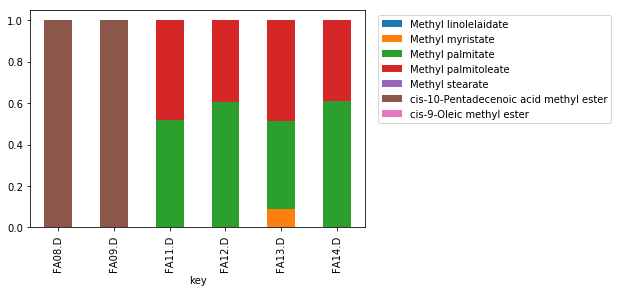

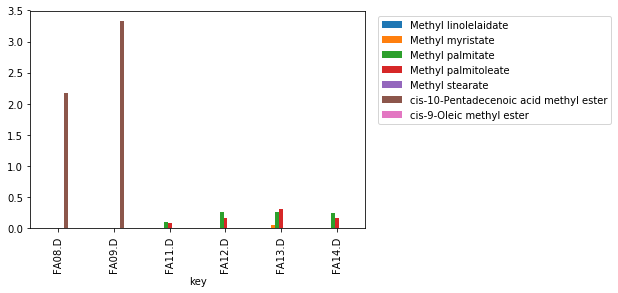

In [7]:
def plot_area(calced_conc,standards = pd.DataFrame()):
    calced_conc = calced_conc.reset_index()
    standard_keys = list(standards.keys()[1:])
    
    #Standards Plot
#     standards_df = calced_conc_tic[calced_conc_tic['key'].isin(standard_keys)]
#     standards_pvt = pd.pivot_table(standards_df,
#                                index='key',
#                                columns='library_id',
#                                values='conc')
#     standards_plt = standards_pvt.plot(legend=True,
#                     kind='line',
#                     stacked=True,
#                     figsize = (6,4))

#     standards_plt.legend(bbox_to_anchor=(1,0,1, 1),loc='upper right')
    
    #Concetration Stacked Percentage Plot
    unknowns_per_df = calced_conc[-calced_conc['key'].isin(standard_keys)]
    unknowns_per_pvt = pd.pivot_table(unknowns_per_df,
                               index='key',
                               columns='library_id',
                               values='conc%')
    unknowns_per_plt = unknowns_per_pvt.plot(legend=True,
                    kind='bar',
                    stacked=True,
                    figsize = (6,4))
    unknowns_per_plt.legend(bbox_to_anchor=(0.75,0,1, 1),loc='upper right')
    
    #Concentration Plot
    unknowns_df = calced_conc[-calced_conc['key'].isin(standard_keys)]
    unknowns_pvt = pd.pivot_table(unknowns_df,
                               index='key',
                               columns='library_id',
                               values='conc')
    unknowns_plt = unknowns_pvt.plot(legend=True,
                    kind='bar',
                    stacked=False,
                    figsize = (6,4))
    unknowns_plt.legend(bbox_to_anchor=(0.75,0,1, 1),
                        loc='upper right')
    return {'percentage':unknowns_per_pvt,'concentrations':unknowns_pvt,'standards':standards}

plot_area(calced_conc,standards)['concentrations'].head()


Fuctions which still need to be built

In [8]:


def make_plot_percentarea():
    pass

def make_plot_concarea():
    pass

def make_plot_massarea():
    pass

def calc_mass():
    pass